# SMC & SMC'

In [1]:
# Import packages.
import matplotlib
from matplotlib import pyplot as plt
import msprime
import numpy as np
import pandas as pd
import smc_funcs as sf
# Print version numbers.
print('matplotlib', matplotlib.__version__)
print('msprime', msprime.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)

matplotlib 3.6.3
msprime 1.2.0
numpy 1.23.5
pandas 1.5.3


In [2]:
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.constrained_layout.use': True,
    'figure.facecolor': 'white',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
})

## Validation (not working just quite yet...)

### Number of Recombination Events

In [3]:
# Define a function to extract the number of recombination events from a tskit ARG.
def extract_n_recomb_events(ts_arg):
    return np.unique(ts_arg.tables.nodes[ts_arg.tables.nodes.flags > 1].time).size

In [4]:
# Intialize an lisy of populuation recombination rate values.
rhos = np.array([0.1, 1, 10, 100, 1_000])
# Intialize a dictionary to store the receombination event results.
recomb_dicc = {
    'standard': np.zeros(rhos.size),
    'msp_smc': np.zeros(rhos.size),
    'djp_smc': np.zeros(rhos.size),
    'msp_smc_prime': np.zeros(rhos.size),
    'djp_smc_prime': np.zeros(rhos.size),
}
# For every population recombination rate.
for i, rho in enumerate(rhos):
    # Assuming Ne = 1, compute r.
    r = rho / 4
    # For 1000 replicate simulations.
    for _ in range(1000):
        # Simulate tree-sequences.
        ts_standard = msprime.sim_ancestry(
            samples=[msprime.SampleSet(2, ploidy=1)],
            population_size=1,
            ploidy=2,
            recombination_rate=r,
            sequence_length=1,
            record_full_arg=True,
            discrete_genome=False,
        )
        ts_msp_smc = msprime.sim_ancestry(
            samples=[msprime.SampleSet(2, ploidy=1)],
            population_size=1,
            ploidy=2,
            recombination_rate=r,
            sequence_length=1,
            model='smc',
            record_full_arg=True,
            discrete_genome=False,
        )
        ts_msp_smc_prime = msprime.sim_ancestry(
            samples=[msprime.SampleSet(2, ploidy=1)],
            population_size=1,
            ploidy=2,
            recombination_rate=r,
            sequence_length=1,
            model='smc_prime',
            record_full_arg=True,
            discrete_genome=False,
        )
        ts_djp_smc = sf.sim_ts_smc(k=2, Ne=1, rho=rho, ploidy=2)
        ts_djp_smc_prime, n_hidden_events = sf.sim_ts_smc_prime(k=2, Ne=1, rho=rho, ploidy=2)
        # Update the dictionary.
        recomb_dicc['standard'][i] += extract_n_recomb_events(ts_standard)
        recomb_dicc['msp_smc'][i] += extract_n_recomb_events(ts_msp_smc)
        recomb_dicc['djp_smc'][i] += ts_djp_smc.num_trees
        recomb_dicc['msp_smc_prime'][i] += extract_n_recomb_events(ts_msp_smc_prime)
        recomb_dicc['djp_smc_prime'][i] += (ts_djp_smc_prime.num_trees + n_hidden_events)

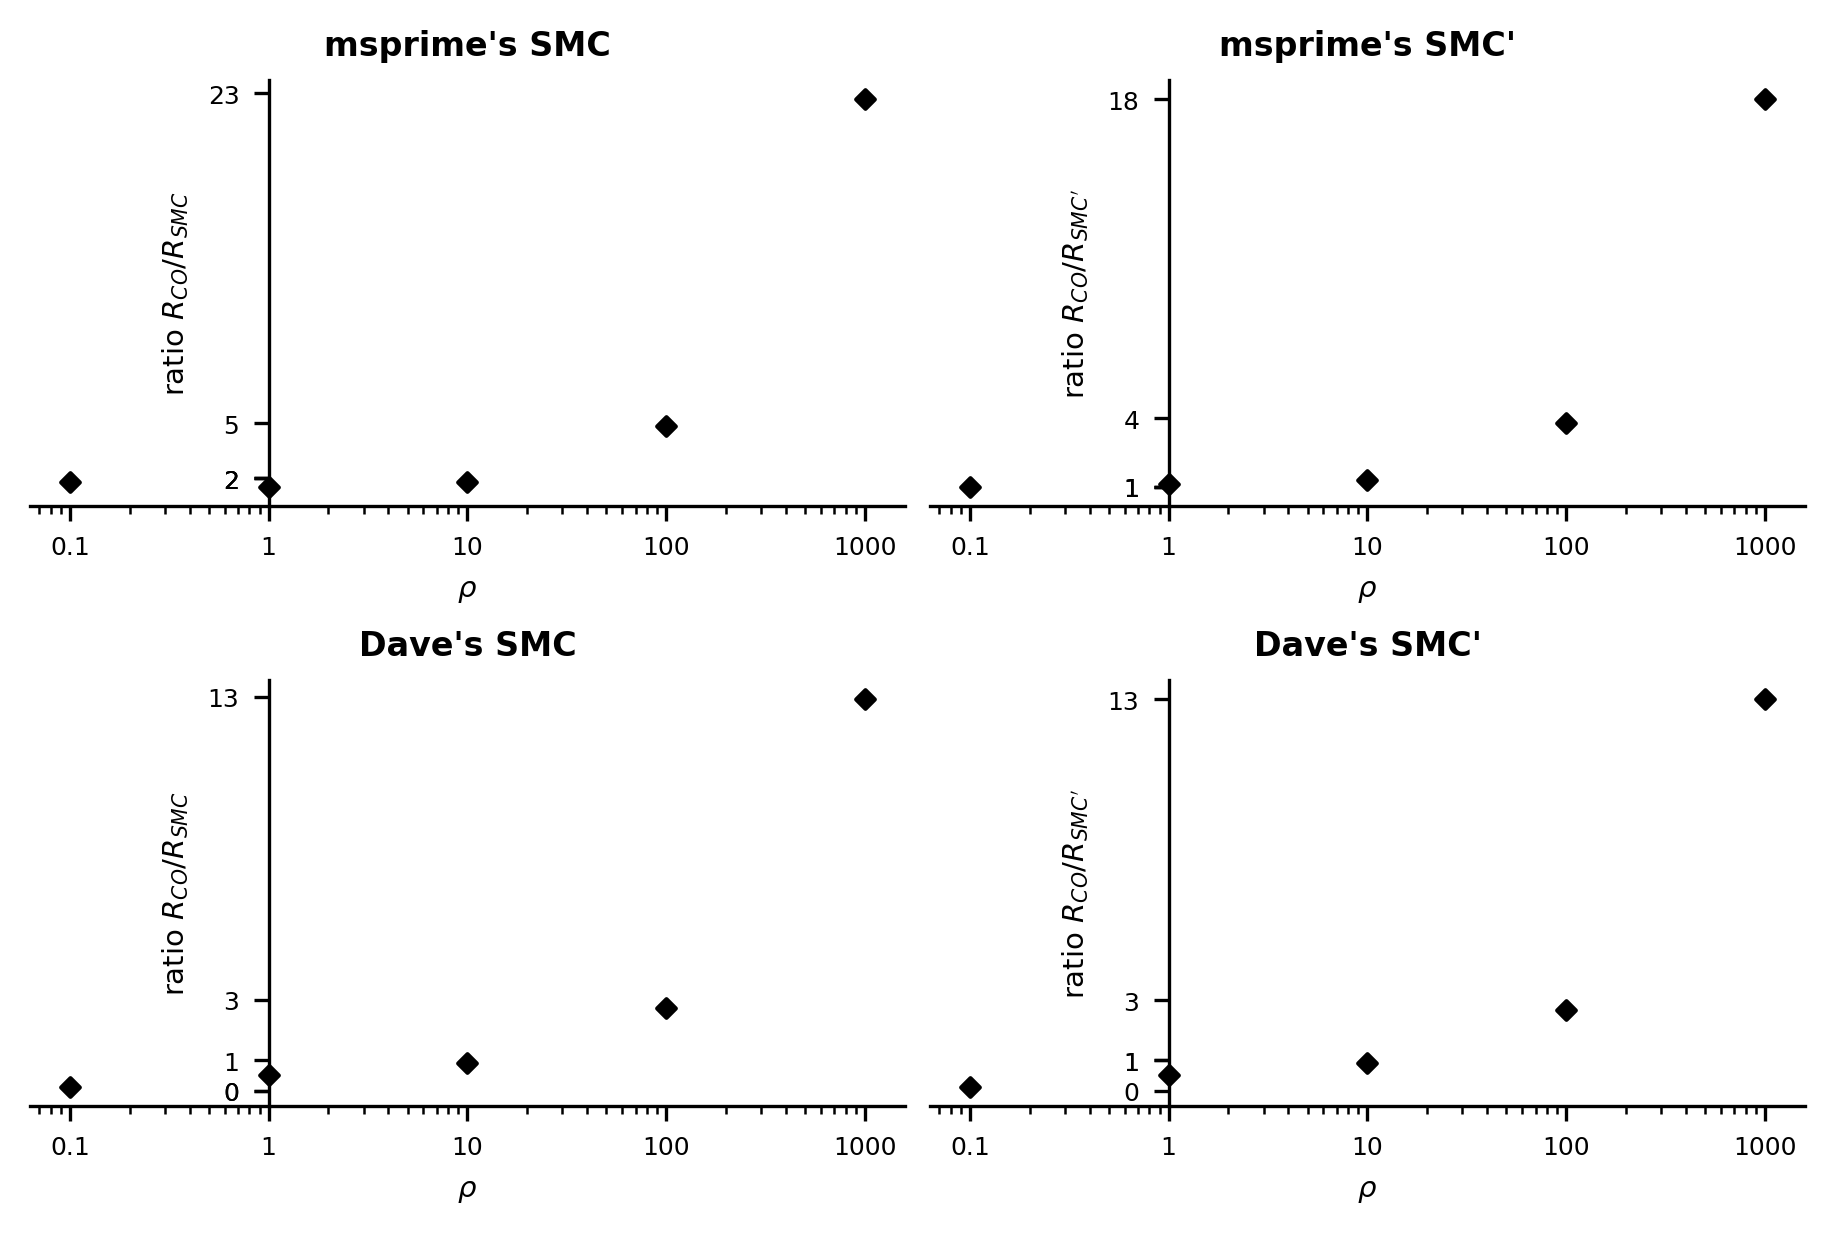

In [5]:
# Intialize figures and axes.
fig, axes = plt.subplots(
     2, 2, figsize=(6, 4),
    sharex=False, sharey=False, dpi=300,
)
# Intialize a dictionary for plotting.
plot_dicc = {
    'msp_smc': {'title': 'msprime\'s SMC', 'y_lab': r'ratio $R_{CO} / R_{SMC}$'},
    'msp_smc_prime': {'title': 'msprime\'s SMC\'', 'y_lab': r'''ratio $R_{CO} / R_{SMC'}$'''},
    'djp_smc': {'title': 'Dave\'s SMC', 'y_lab': r'ratio $R_{CO} / R_{SMC}$'},
    'djp_smc_prime': {'title': 'Dave\'s SMC\'', 'y_lab': r'''ratio $R_{CO} / R_{SMC'}$'''},
}
# Intialize axes list.
ax_list = [
    (0, 0), (0, 1),
    (1, 0), (1, 1),
]
# Intialize the mean number of crossovers for the standard coalescent.
standard_mean_co = recomb_dicc['standard'] / 1_000
# For every key.
for i, key in enumerate(plot_dicc):
    # Unpack the row and column indicies.
    row, col = ax_list[i]
    # Compute the R ratio.
    R_ratio = standard_mean_co / (recomb_dicc[key] / 1_000)
    # Plot the the results.
    axes[row, col].scatter(
        rhos, R_ratio, color='black',
        marker='D', s=10,
    )
    # Set the subplot title.
    axes[row, col].set_title(plot_dicc[key]['title'], fontweight='bold', size=8)
    # Set the axes labels.
    axes[row, col].set_xlabel(r'$\rho$', size=7)
    axes[row, col].set_ylabel(plot_dicc[key]['y_lab'], size=7)
    # Move the left spine (y-axis bar) to x = 1.
    axes[row, col].spines['left'].set_position(('data', 1))
    # Set the x-axis scale.
    axes[row, col].set_xscale('log')
    # Set the y-axis ticks and tick labels.
    axes[row, col].set_yticks(np.round(R_ratio))
    axes[row, col].set_yticklabels([str(round(ratio)) for ratio in R_ratio], size=6)
    # Set the axes scale, ticks, and tick labels.
    axes[row, col].set_xticks(rhos)
    axes[row, col].set_xticklabels([str(int(rho)) if rho.is_integer() else str(rho) for rho in rhos], size=6)
# Export the plot.
plt.savefig(
    './R_ratio_v02.png', format='png',
    facecolor='white', bbox_inches='tight', dpi=500,
)
# Show the plot.
plt.show()

In [8]:
# Intialize a data frame dictionary.
df_dicc = {}
# Intialize a list for column names.
col_names = [
    'msprime\'s Standard Coalescent $\hat{R_{CO}}$',
    r'''msprime's $\hat{R_{SMC}}$''', r'''msprime's $\hat{R_{SMC'}}$''',
    r'''Dave's $\hat{R_{SMC}}$''', r'''Dave's $\hat{R_{SMC'}}$''',
]
# For every key.
for i, key in enumerate(['standard', 'msp_smc', 'msp_smc_prime', 'djp_smc', 'djp_smc_prime']):
    # Compute the mean R.
    R_mean = (recomb_dicc[key] / 1_000)
    # Update the dictionary.
    df_dicc[col_names[i]] = np.round(R_mean, 3)
# Convert the dictionary to a data frame.
R_mean_df = pd.DataFrame(
    data=df_dicc,
    index=[r'$\rho =$ '+str(int(rho)) if rho.is_integer() else r'$\rho =$ '+str(rho) for rho in rhos],
)
# Export for good measures.
R_mean_df.to_csv('./R_mean_v02.csv', index=False)

In [9]:
# Show the mean R results.
R_mean_df

,msprime's Standard Coalescent $\hat{R_{CO}}$,msprime's $\hat{R_{SMC}}$,msprime's $\hat{R_{SMC'}}$,Dave's $\hat{R_{SMC}}$,Dave's $\hat{R_{SMC'}}$
$\rho =$ 0.1,0.152,0.084,0.153,1.214,1.215
$\rho =$ 1,1.504,0.989,1.351,3.010,2.950
$\rho =$ 10,19.155,10.762,14.641,21.241,20.571
$\rho =$ 100,543.755,112.901,142.626,200.063,203.050
$\rho =$ 1000,25957.699,1145.573,1442.920,2009.487,1997.843


In [10]:
# Intialize a data frame dictionary.
df_dicc = {}
# Intialize a list for column names.
col_names = [
    r'''msprime's $R_{CO} / R_{SMC}$''', r'''msprime's $R_{CO} / R_{SMC'}$''',
    r'''Dave's $R_{CO} / R_{SMC}$''', r'''Dave's $R_{CO} / R_{SMC'}$''',
]
# Intialize the mean number of crossovers for the standard coalescent.
standard_mean_co = recomb_dicc['standard'] / 1_000
# For every key.
for i, key in enumerate(['msp_smc', 'msp_smc_prime', 'djp_smc', 'djp_smc_prime']):
    # Compute the R ratio.
    R_ratio = standard_mean_co / (recomb_dicc[key] / 1_000)
    # Update the dictionary.
    df_dicc[col_names[i]] = np.round(R_ratio, 3)
# Convert the dictionary to a data frame.
R_ratio_df = pd.DataFrame(
    data=df_dicc,
    index=[r'$\rho =$ '+str(int(rho)) if rho.is_integer() else r'$\rho =$ '+str(rho) for rho in rhos],
)
# Export for good measures.
R_ratio_df.to_csv('./R_ratio_v02.csv', index=False)

In [11]:
# Show the R ratio results.
R_ratio_df

,msprime's $R_{CO} / R_{SMC}$,msprime's $R_{CO} / R_{SMC'}$,Dave's $R_{CO} / R_{SMC}$,Dave's $R_{CO} / R_{SMC'}$
$\rho =$ 0.1,1.810,0.993,0.125,0.125
$\rho =$ 1,1.521,1.113,0.500,0.510
$\rho =$ 10,1.780,1.308,0.902,0.931
$\rho =$ 100,4.816,3.812,2.718,2.678
$\rho =$ 1000,22.659,17.990,12.918,12.993


## Tree Height

In [12]:
# Define a function to extract the tmrca from the ith tree.
def extract_ith_tmrca(ts, ith_tree):
    # If the ith tree exists.
    if ts.num_trees > ith_tree:
        # Extract the tmrca.
        ith_tmrca = ts.at_index(ith_tree).time(ts.at_index(ith_tree).root)
    # Else, the ith tree doesn't exist.
    else:
        ith_tmrca = np.nan
    return ith_tmrca

In [ ]:
# Define a list of tree indicies.
tree_idx = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1])
# Intialize an lisy of populuation recombination rate values.
rhos = np.array([1, 100])
# Intialize sample sizes.
ns = np.array([2, 20])
# Intialize a dictionary to store the receombination event results.
height_dicc = {
    'standard': {},
    'msp_smc': {},
    'djp_smc': {},
    'msp_smc_prime': {},
    'djp_smc_prime': {},
}
# For every sample size.
for n in ns:
    # Intialize subdictionaries.
    for key in height_dicc:
        height_dicc[key][n] = {}
    # For every population recombination rate.
    for rho in rhos:
        # Intialize subdictionaries.
        for key in height_dicc:
            height_dicc[key][n][rho] = {}
        # Assuming Ne = 1, compute r.
        r = rho / 4
        # For every tree index.
        for idx in tree_idx:
            # Intialize subdictionaries.
            for key in height_dicc:
                height_dicc[key][n][rho][idx] = []
            # For 1000 replicate simulations.
            for _ in range(1000):
                # Simulate tree-sequences.
                ts_standard = msprime.sim_ancestry(
                    samples=[msprime.SampleSet(n, ploidy=1)],
                    population_size=1,
                    ploidy=2,
                    recombination_rate=r,
                    sequence_length=1,
                    discrete_genome=False,
                )
                ts_msp_smc = msprime.sim_ancestry(
                    samples=[msprime.SampleSet(n, ploidy=1)],
                    population_size=1,
                    ploidy=2,
                    recombination_rate=r,
                    sequence_length=1,
                    model='smc',
                    discrete_genome=False,
                )
                ts_msp_smc_prime = msprime.sim_ancestry(
                    samples=[msprime.SampleSet(n, ploidy=1)],
                    population_size=1,
                    ploidy=2,
                    recombination_rate=r,
                    sequence_length=1,
                    model='smc_prime',
                    discrete_genome=False,
                )
                ts_djp_smc = sf.sim_ts_smc(k=n, Ne=1, rho=rho, ploidy=2)
                ts_djp_smc_prime, _ = sf.sim_ts_smc_prime(k=n, Ne=1, rho=rho, ploidy=2)
                # Update the dictionary.
                height_dicc['standard'][n][rho][idx].append(extract_ith_tmrca(ts=ts_standard, ith_tree=idx))
                height_dicc['msp_smc'][n][rho][idx].append(extract_ith_tmrca(ts=ts_msp_smc, ith_tree=idx))
                height_dicc['djp_smc'][n][rho][idx].append(extract_ith_tmrca(ts=ts_djp_smc, ith_tree=idx))
                height_dicc['msp_smc_prime'][n][rho][idx].append(extract_ith_tmrca(ts=ts_msp_smc_prime, ith_tree=idx))
                height_dicc['djp_smc_prime'][n][rho][idx].append(extract_ith_tmrca(ts=ts_djp_smc_prime, ith_tree=idx))

In [219]:
# Intialize a dataframe dictionary.
df_dicc = {
    r'Sampled Lineages $(n)$': [],
    r'Population Recombination Rate $(\rho)$': [],
    r'$i$th Tree': [],
    'msprime Standard Coalescent': [],
    'msprime\'s SMC': [],
    'msprime\'s SMC\'': [],
    'Dave\'s SMC': [],
    'Dave\'s SMC\'': [],
}
# For every sample size.
for n in ns:
    # For every population recombination rate.
    for rho in rhos:
        # For every tree index.
        for idx in tree_idx:
            # If the ith tree is not the last tree index.
            if idx != -1:
                # Add one to account for 0-indexing.
                ith = int(idx + 1)
            # Else.
            else:
                # Denote that this is the last tree.
                ith = 'last tree'
            # Update the dictionary with the simulation paramters and mean tmrca.
            df_dicc[r'Sampled Lineages $(n)$'].append(n)
            df_dicc[r'Population Recombination Rate $(\rho)$'].append(rho)
            df_dicc[r'$i$th Tree'].append(ith)
            df_dicc['msprime Standard Coalescent'].append(np.nanmean(np.array(height_dicc['standard'][n][rho][idx])))
            df_dicc['msprime\'s SMC'].append(np.nanmean(np.array(height_dicc['msp_smc'][n][rho][idx])))
            df_dicc['msprime\'s SMC\''].append(np.nanmean(np.array(height_dicc['msp_smc_prime'][n][rho][idx])))
            df_dicc['Dave\'s SMC'].append(np.nanmean(np.array(height_dicc['djp_smc'][n][rho][idx])))
            df_dicc['Dave\'s SMC\''].append(np.nanmean(np.array(height_dicc['djp_smc_prime'][n][rho][idx])))
# Convert the dictionary to a data frame.
height_df = pd.DataFrame(data=df_dicc)
# Export for good measures.
height_df.to_csv('./tree_height_v01.csv', index=False)

/var/folders/nr/v5td4f0d4c52kd3_ynmvd7r40000gn/T/ipykernel_18112/4187593955.py:32: RuntimeWarning: Mean of empty slice
  df_dicc['msprime\'s SMC\''].append(np.nanmean(np.array(height_dicc['msp_smc_prime'][n][rho][idx])))
/var/folders/nr/v5td4f0d4c52kd3_ynmvd7r40000gn/T/ipykernel_18112/4187593955.py:30: RuntimeWarning: Mean of empty slice
  df_dicc['msprime Standard Coalescent'].append(np.nanmean(np.array(height_dicc['standard'][n][rho][idx])))
/var/folders/nr/v5td4f0d4c52kd3_ynmvd7r40000gn/T/ipykernel_18112/4187593955.py:34: RuntimeWarning: Mean of empty slice
  df_dicc['Dave\'s SMC\''].append(np.nanmean(np.array(height_dicc['djp_smc_prime'][n][rho][idx])))
/var/folders/nr/v5td4f0d4c52kd3_ynmvd7r40000gn/T/ipykernel_18112/4187593955.py:31: RuntimeWarning: Mean of empty slice
  df_dicc['msprime\'s SMC'].append(np.nanmean(np.array(height_dicc['msp_smc'][n][rho][idx])))
/var/folders/nr/v5td4f0d4c52kd3_ynmvd7r40000gn/T/ipykernel_18112/4187593955.py:33: RuntimeWarning: Mean of empty slice
  

In [220]:
# Show the simulated tree height results.
height_df

,Sampled Lineages $(n)$,Population Recombination Rate $(\rho)$,$i$th Tree,msprime Standard Coalescent,msprime's SMC,msprime's SMC',Dave's SMC,Dave's SMC'
0,2,1,1,1.950295,2.012973,1.931305,1.974963,1.950352
1,2,1,2,3.510007,3.305729,3.151048,1.049752,1.174254
2,2,1,3,4.352928,4.289646,3.768193,0.847214,1.085618
3,2,1,4,4.249656,4.735264,4.228944,0.801101,1.030320
4,2,1,5,2.977198,4.462544,3.626483,0.645693,1.224116
5,2,1,6,4.532595,5.459215,5.872172,0.768243,1.035533
6,2,1,7,3.987870,4.702234,NaN,0.928363,0.953669
7,2,1,8,NaN,3.859312,NaN,0.991505,NaN
8,2,1,9,NaN,1.064392,NaN,0.069627,NaN
9,2,1,10,NaN,NaN,NaN,0.221849,NaN


## Code in `smc_funcs.py` for Debugging

In [234]:
# Define a function to simulate T_{0}.
def sim_T0(k, Ne, ploidy, seed=None):
    """
    Returns the tables, root node id, and total branch length of a tree simulated under the standard coalescent.
    
    k      -- Number of chromosomes to simulate.
    Ne     -- Effective population size.
    ploidy -- Haploid or diploid coalescent units.
    seed   -- Random seed for reporducibility.
    """
    # Simulate a tree under the standard coalescent.
    ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(k, ploidy=1)],
        population_size=Ne,
        ploidy=ploidy,
        random_seed=seed,
        discrete_genome=False,
    )
    # Make a copy of the tree-seq tables for editting.
    ts_tables = ts.dump_tables()
    # Extract the root node id.
    root_id = ts.first().root
    # Extract the total branch length.
    Lx = ts.first().total_branch_length
    
    print('T_{0}:')
    print(ts.draw_text())
    return ts_tables, root_id, Lx

# Define a function to extract the current tree's information.
def extract_tree_info(node_table, edge_table, right):
    """
    Returns the edge information and the total branch length of the current tree.
    
    node_table -- Tskit node table.
    edge_table -- Tskit edge table.
    right      -- The position of the recombination event.
    """
    # Mask the edge table for the current tree.
    edge_mask = (edge_table.right == right)
    c_tree_edge_table = edge_table[edge_mask]
    # Intialize a dictionary for the current tree.
    c_tree_dicc = {}
    # Intialize the total branch length of the tree.
    Lx = 0
    # For every edge on the current tree.
    for i in range(edge_mask.sum()):
        # Intialize the subdictionary for the edge.
        c_tree_dicc[i] = {}
        # Update the pertentient information to the dictionary.
        c_tree_dicc[i]['parent'] = c_tree_edge_table.parent[i]
        c_tree_dicc[i]['child'] = c_tree_edge_table.child[i]
        c_tree_dicc[i]['upper'] = node_table.time[c_tree_dicc[i]['parent']]
        c_tree_dicc[i]['lower'] = node_table.time[c_tree_dicc[i]['child']]
        c_tree_dicc[i]['length'] = c_tree_dicc[i]['upper'] - c_tree_dicc[i]['lower']
        Lx += c_tree_dicc[i]['length']
    return c_tree_edge_table, c_tree_dicc, Lx

# Define a function to determine the distance to the next recombination event.
def draw_y(rho, Lx, ploidy):
    """
    Returns the distance to the next recombination event.
    
    rho    -- Population recombination rate.
    Lx     -- Total branch length of T_{x}.
    ploidy -- Haploid or diploid coalescent units.
    """
    # Draw y.
    y = np.random.exponential((1 / ((rho / ploidy) * Lx)))
    return y

# Define a function to determine the the lineage and age of the recombination event.
def draw_g(c_tree_dicc, Lx):
    """
    Returns the recombination event information for the current tree.
    
    c_tree_dicc      -- Dictionary of the current tree's edges.
    Lx               -- Total branch length of T_{x}.
    """
    # Compute the edge weights (ie edge_length/L(x)).
    edge_weights = [(c_tree_dicc[key]['length'] / Lx) for key in c_tree_dicc.keys()]
    # Determine which edge will have the recombinatin event.
    rec_edge_key = np.random.choice(list(c_tree_dicc.keys()), p=edge_weights)
    # Determine the age of the recombination event.
    g = np.random.uniform(c_tree_dicc[rec_edge_key]['lower'], c_tree_dicc[rec_edge_key]['upper'])
    return rec_edge_key, g

# Define a function to determine the lineage and age of the next coalescent event for the smc' model.
def draw_coal_smc_prime(node_table, c_tree_edge_table, c_tree_dicc, g, Ne, ploidy):
    """
    Returns the edge and coalescent information for the next tree.
    
    node_table        -- Tskit node table.
    c_tree_edge_table -- Tskit edge table of the current tree.
    c_tree_dicc       -- Dictionary of the current tree's edges.
    g                 -- Age of the recombination event on the current tree.
    Ne                -- Effective population size.
    ploidy            -- Haploid or diploid coalescent units.
    """
    # Determine the upper bounds of the time intervals where coalescence can occur on the current tree.
    upper_bounds = [node_table.time[i] for i in np.unique(c_tree_edge_table.parent)]
    # Sort the upper bounds by age.
    sorted_upper_bounds = sorted(upper_bounds)
    # Determine the root node id.
    root_node = np.where(node_table.time == max(sorted_upper_bounds))[0].max()
    # Intialize the lower bound of the first interval.
    c_lower_bound = 0
    # Intialize the key of the edge where the coalescent event will occur.
    coal_edge_key = None
    # For every possible coalescent interval.
    for i, c_upper_bound in enumerate(sorted_upper_bounds):
        # Determine if the recombination event occurs below the upper bound of the current interval.
        if c_upper_bound > g:
            # Determine the avaiable lineages in this interval.
            available_lineages = [
                key for key in c_tree_dicc.keys() if\
                ((c_tree_dicc[key]['upper'] >= c_upper_bound) & (c_tree_dicc[key]['lower'] <= c_lower_bound))
            ] ### YOU CAN ADD THE CONDITION (key != rec_edge_key) FOR SMC ###
            # Determine the time of the coalescent event.
            coal_time = g + np.random.exponential(((Ne * ploidy) / len(available_lineages)))
            # If the the coalescent event occurs within the current time interval.
            if c_upper_bound > coal_time > c_lower_bound:
                # Determine which edge the coalescent event occurs on.
                coal_edge_key = np.random.choice(available_lineages)
                break
            # Else, re-intialize the lower bound and move on to the next interval.
            else:
                c_lower_bound = c_upper_bound
        # Else, re-intialize the lower bound and move on to the next interval.
        else:
            c_lower_bound = c_upper_bound
    # If an edge was not found within the current tree's interval.
    if coal_edge_key == None:
        # Determine the new time of coalescences above the root.
        coal_time = node_table.time[root_node] + np.random.exponential(1 / (Ne * ploidy))
    return coal_edge_key, coal_time, root_node

# Define a function to determine the lineage and age of the next coalescent event for the smc model.
def draw_coal_smc(node_table, c_tree_edge_table, c_tree_dicc, rec_edge_key, g, Ne, ploidy):
    """
    Returns the edge and coalescent information for the next tree.
    
    node_table        -- Tskit node table.
    c_tree_edge_table -- Tskit edge table of the current tree.
    c_tree_dicc       -- Dictionary of the current tree's edges.
    rec_edge_key      -- Key of the edge with the recombination event in c_tree_dicc.
    g                 -- Age of the recombination event on the current tree.
    Ne                -- Effective population size.
    ploidy            -- Haploid or diploid coalescent units.
    """
    # Determine the upper bounds of the time intervals where coalescence can occur on the current tree.
    upper_bounds = [node_table.time[i] for i in np.unique(c_tree_edge_table.parent)]
    # Sort the upper bounds by age.
    sorted_upper_bounds = sorted(upper_bounds)
    # Determine the root node id.
    root_node = np.where(node_table.time == max(sorted_upper_bounds))[0].max()
    # Intialize the lower bound of the first interval.
    c_lower_bound = 0
    # Intialize the key of the edge where the coalescent event will occur.
    coal_edge_key = None
    # For every possible coalescent interval.
    for i, c_upper_bound in enumerate(sorted_upper_bounds):
        # Determine if the recombination event occurs below the upper bound of the current interval.
        if c_upper_bound > g:
            # Determine the avaiable lineages in this interval.
            available_lineages = [
                key for key in c_tree_dicc.keys() if\
                ((c_tree_dicc[key]['upper'] >= c_upper_bound)\
                & (c_tree_dicc[key]['lower'] <= c_lower_bound)\
                & (key != rec_edge_key))
            ]
            # If there are avaiable lineages.
            if len(available_lineages) > 0:
                # Determine the time of the coalescent event.
                coal_time = g + np.random.exponential(((Ne * ploidy) / len(available_lineages)))
            # Else set the coalescent event to a variable that will fail.
            else:
                coal_time = -1
            # If the the coalescent event occurs within the current time interval.
            if c_upper_bound > coal_time > c_lower_bound:
                # Determine which edge the coalescent event occurs on.
                coal_edge_key = np.random.choice(available_lineages)
                break
            # Else, re-intialize the lower bound and move on to the next interval.
            else:
                c_lower_bound = c_upper_bound
        # Else, re-intialize the lower bound and move on to the next interval.
        else:
            c_lower_bound = c_upper_bound
    # If an edge was not found within the current tree's interval.
    if coal_edge_key == None:
        # Determine the new time of coalescences above the root.
        coal_time = node_table.time[root_node] + np.random.exponential((Ne * ploidy))
    return coal_edge_key, coal_time, root_node

# Define a function to perform a subtree pruning and regrafting that is compatible with tskit.
def ts_spr(
    k,
    node_table,
    edge_table,
    c_tree_edge_table,
    c_tree_dicc,
    rec_edge_key,
    coal_edge_key,
    coal_time,
    right,
    root_node,
    node_id,
):
    """
    Returns the updated node and edge table after performing the SPR algorithim.
    
    k                 -- Number of sampled chromosomes.
    node_table        -- Tskit node table.
    edge_table        -- Tskit edge table.
    c_tree_edge_table -- Tskit edge table of the current tree.
    c_tree_dicc       -- Dictionary of the current tree's edges.
    rec_edge_key      -- Key of the edge with the recombination event in c_tree_dicc.
    coal_edge_key     -- Key of the edge with the coalescent event in c_tree_dicc.
    coal_time         -- Time of the next coalescent event.
    right             -- The position of the recombination event.
    root_node         -- ID of the root node on the current tree.
    node_id           -- ID of the next node for Tskit compatability.
    """
    ### HIDDEN RECOMBINATION SCENARIO ###
    # If the coalescent event is hidden (ie recombination and coalesence occur on the same branch).
    if rec_edge_key == coal_edge_key:
        # For every edge on the current tree.
        for key in c_tree_dicc.keys():
            # Extract the row index.
            row_idx = np.where(
                (edge_table.parent == c_tree_dicc[key]['parent']) & (edge_table.child == c_tree_dicc[key]['child'])
            )[0][0]
            # Update the edge table.
            edge_table[row_idx] = edge_table[row_idx].replace(right=1.0)
            
        print('hidden coalescent event')
        print(f'edge expirencing recombination: {c_tree_dicc[rec_edge_key]}')
        print(f'coalescent event age: {coal_time}')
    
    # Else, the coalescent event is not hidden.
    else:
        ### INTIALIZING TREE INFORMATION FOR SPR ###
        # Intialize a dictionary of parent nodes and children for the current tree.
        c_parent_dicc = {}
        # For every unique parent.
        for parent in np.unique(c_tree_edge_table.parent):
            # Intialize the entry
            c_parent_dicc[parent] = {
                'time': node_table.time[parent],
                'children': c_tree_edge_table[c_tree_edge_table.parent == parent].child,
            }
        # Idenitfy the broken node (ie the parent node directly above g).
        broken_node = c_tree_dicc[rec_edge_key]['parent']
        # Identify the node to be inherited (ie the parent node directly below g).
        inherited_node = c_tree_dicc[rec_edge_key]['child']
        # Idenitfy the lonely node not inherited (ie the child node of the broken node not inherited).
        lonely_node = np.setdiff1d(c_parent_dicc[broken_node]['children'], inherited_node)[0]
        # If the new coalescent event is above the current root node.
        if coal_edge_key == None:
            # Set the root node as the node below the new coalescent event.
            below_node = root_node
        # Else, the new coalescent event occurs on a current edge.
        else:
            # Identify the node below the new coalescent event.
            below_node = c_tree_dicc[coal_edge_key]['child']
            
        # Print a summary of what actually happened.
        print(f'edge expirencing recombination: {c_tree_dicc[rec_edge_key]}')
        print(f'coalescent event age: {coal_time}')
        if coal_edge_key == None:
            print('the coalescent event was above the root node')
        else:
            print(f'edge expirencing coalescences: {c_tree_dicc[coal_edge_key]}')
        print(f'broken node id: {broken_node}')
        print(f'inherited node id: {inherited_node}')
        print(f'lonely node id: {lonely_node}')
        print(f'below coal node id: {below_node}')
        
        ### SPR ###
        # Intialize a dictionary to store the next tree's information.
        n_parent_dicc = c_parent_dicc.copy()
        # If the broken node is the root node and the coalescent event is above the root.
        if (broken_node == root_node) & (coal_edge_key == None):
            # Set the new coalescent as the parent node with the inherited and lonely nodes as its chidren.
            n_parent_dicc[None] = {
                'time': coal_time,
                'children': np.array([inherited_node, lonely_node], dtype='int32'),
            }
        # Else if, the broken node is the node bewlow the coalescent event.
        elif (broken_node == below_node) & (coal_edge_key != None):
            # Set the new coalescent as the parent node with the inherited and lonely nodes as its chidren.
            n_parent_dicc[None] = {
                'time': coal_time,
                'children': np.array([inherited_node, lonely_node], dtype='int32'),
            }
        # Else.
        else:
            # Set the new coalescent as the parent node with the inherited and below nodes as its chidren.
            n_parent_dicc[None] = {
                'time': coal_time,
                'children': np.array([inherited_node, below_node], dtype='int32'),
            }
        # If the below node has a parent node on the current tree.
        if (below_node != root_node) & (below_node != lonely_node):
            # Replace the below node with the new coalescent event node in the children's set.
            n_parent_dicc[c_tree_dicc[coal_edge_key]['parent']]['children'] = np.where(
                c_parent_dicc[c_tree_dicc[coal_edge_key]['parent']]['children'] == below_node,
                None, c_parent_dicc[c_tree_dicc[coal_edge_key]['parent']]['children'],
            )
        # If the broken node has a parent node on the current tree.
        if (broken_node != root_node) & (below_node != lonely_node):
            # Determine the parent node of broken node.
            broken_node_parent = c_tree_edge_table[np.where((c_tree_edge_table.child == broken_node))[0][0]].parent
            # Replace the broken node as the lonely node in the parent's node children set.
            n_parent_dicc[broken_node_parent]['children'] = np.where(
                c_parent_dicc[broken_node_parent]['children'] == broken_node,
                lonely_node, c_parent_dicc[broken_node_parent]['children'],
            )
        # Else, if broken node is not the root node.
        elif (broken_node != root_node):
            # Determine the parent node of broken node.
            broken_node_parent = c_tree_edge_table[np.where((c_tree_edge_table.child == broken_node))[0][0]].parent
            # Replace the broken node as the lonely node in the parent's node children set.
            n_parent_dicc[broken_node_parent]['children'] = np.where(
                c_parent_dicc[broken_node_parent]['children'] == broken_node,
                None, c_parent_dicc[broken_node_parent]['children'],
            )
        # Remove the broken node from the next tree.
        del n_parent_dicc[broken_node]
        
        print('new tree info before adjusting node ids')
        for key in n_parent_dicc:
            print(key, n_parent_dicc[key])
        
        ### RE-FORMATTING NODE IDS FOR TSKIT ###
        # Intialize a node id dictionary.
        node_id_dicc = {}
        # Add the node id to the node table.
        node_table.add_row(time=n_parent_dicc[None]['time'], population=0)
        # Update the node id dictionary.
        node_id_dicc[None] = node_id
        # Move the node_id counter forward.
        node_id += 1
        # If the broken node is the parent of the lonely node and the lonely node is not a leaf.
        if (c_tree_edge_table[c_tree_edge_table.child == lonely_node][0].parent == broken_node) & (lonely_node >= k):
            # Update the lonely node id so it is tskit compatible.
            node_table.add_row(time=node_table.time[lonely_node], population=0)
            # Update the node id dictionary.
            node_id_dicc[lonely_node] = node_id
            # Move the node_id counter forward.
            node_id += 1
        # Else-if the below node is the root and the lonely node is a leaf.
        elif (below_node == root_node) & (lonely_node < k):
            # Update the root node id so it is tskit compatible.
            node_table.add_row(time=node_table.time[root_node], population=0)
            # Update the node id dictionary.
            node_id_dicc[root_node] = node_id
            # Move the node_id counter forward.
            node_id += 1
        # For every parent node in the new tree.
        for key in list(n_parent_dicc.keys()):
            # If the node id needs to be updated.
            if key in node_id_dicc:
                # Update the parent node id.
                n_parent_dicc[node_id_dicc[key]] = n_parent_dicc.pop(key)
        # For every new parent node in the new tree.
        for key in n_parent_dicc.keys():
            # Update the children node ids if necessary.
            n_parent_dicc[key]['children'] = np.array(
                [node_id_dicc.get(child, child) for child in n_parent_dicc[key]['children']], dtype='int32',
            )
        
        print('new tree info after adjusting node ids')
        for key in n_parent_dicc:
            print(key, n_parent_dicc[key])
        
        ### UPDATING TSKIT TABLES ###
        # Sort the remaining nodes on the new tree by their age.
        sorted_parent_nodes = sorted(n_parent_dicc.keys(), key=lambda x: n_parent_dicc[x]['time'], reverse=True)
        # Intialize a list of new node ids.
        new_node_ids = list(node_id_dicc.values())
        # For the remaining new parent nodes.
        for n_parent in sorted_parent_nodes:
            # If the parent node is a new id.
            if n_parent in new_node_ids:
                # For every child.
                for child in n_parent_dicc[n_parent]['children']:
                    # Add the new edge to the edge table.
                    edge_table.add_row(
                        left=right, right=1.0,
                        parent=n_parent, child=child,
                    )
            # Else, the parent node is an existing node id.
            else:
                # For every child.
                for child in n_parent_dicc[n_parent]['children']:
                    # If the child node has a new node id.
                    if child in new_node_ids:
                        # Add the new edge to the edge table.
                        edge_table.add_row(
                            left=right, right=1.0,
                            parent=n_parent, child=child,
                        )
                    # Else, the child node id is an existing node.
                    else:
                        # Extract the row index from the complete edge table.
                        row_idx = np.where((edge_table.parent == n_parent) & (edge_table.child == child))[0]
                        # If, this is an existing edge on the current tree.
                        if row_idx.size > 0:
                            # Update the edge table.
                            edge_table[row_idx[0]] = edge_table[row_idx[0]].replace(right=1.0)
                        # Else, this edge is not on the current tree.
                        else:
                            # Add the new edge to the edge table.
                            edge_table.add_row(
                                left=right, right=1.0,
                                parent=n_parent, child=child,
                            )
    return node_table, edge_table, node_id

In [235]:
## (0) Intialize the inputs for the the SMC/SMC' algorithim. ###

k = 3
Ne = 1
rho = 0.1
ploidy = 2
seed = 42
export = False

## (1) Intialize the first tree, T(x)=T_{0}, at position x=0, and compute the total branch length L(x)=L_{0}. ##

# Intialize the start position.
x = 0
# Simulate a tree (T_{0}) under the standard coalescent at point x=0.
smc_tables, root_id, L0 = sim_T0(k=k, Ne=Ne, ploidy=ploidy, seed=seed)
# Extract the tables that we will need to edit.
node_table = smc_tables.nodes
edge_table = smc_tables.edges
# Intialize the next node id for tree-seq compatability.
node_id = root_id + 1

## (2) Generate the distance, y=exp[(rho/2)L(x)], to the next recombination event. ##

# Compute the distance to the next recombination event (y).
y = draw_y(rho=rho, Lx=L0, ploidy=ploidy)

print(f'first interval: ({x}, {y})')

# While we are still within the sequence intervals.
while (x + y) < 1:
    # Intialize the new right position in the edge table.
    edge_table.right = np.where(edge_table.right == 1.0, (x + y), edge_table.right)
    # Intialize the edge information for the current tree.
    c_tree_edge_table, c_tree_dicc, Lx = extract_tree_info(
        node_table=node_table, edge_table=edge_table, right=(x + y),
    )

## (3) Determine the location (ie what edge), and the age of the recombination event (g). ##

    # Determine g and its location on the current tree.
    rec_edge_key, g = draw_g(c_tree_dicc=c_tree_dicc, Lx=Lx)
    
    print(f'recombination event age: {g}')
    

## (4) Overlay the recombination event at time g and allow the branch below g to coalesce elsewhere on the tree. ##

    # Deteremine the location and time of the recombining coalescent event.
#     coal_edge_key, coal_time, root_node = draw_coal_smc_prime(
#         node_table=node_table, c_tree_edge_table=c_tree_edge_table, c_tree_dicc=c_tree_dicc,
#         g=g, Ne=Ne, ploidy=ploidy,
#     )
    
    coal_edge_key, coal_time, root_node = draw_coal_smc(
        node_table=node_table, c_tree_edge_table=c_tree_edge_table, c_tree_dicc=c_tree_dicc,
        rec_edge_key=rec_edge_key, g=g, Ne=Ne, ploidy=ploidy,
    )
    
    print(f'root node: {root_node}')
    print('--------------------------------------------------------------------------------')

## (5) Prune the old branch above g and graft the new branch to construct the next tree at position x+y. ##

    # Perform the SPR that is compatible with tskit.
    node_table, edge_table, node_id = ts_spr(
        k=k, node_table=node_table, edge_table=edge_table, c_tree_edge_table=c_tree_edge_table,
        c_tree_dicc=c_tree_dicc, rec_edge_key=rec_edge_key, coal_edge_key=coal_edge_key,
        coal_time=coal_time, right=(x + y), root_node=root_node, node_id=node_id,
    )

## (6) Reset the new interval x=x+y, intialize the new tree as the current tree T(x), and compute the compute the total branch length L(x). ##

    # Reset the new left interval (x).
    x = (x + y)
    # Extract the total branch length of the next tree.
    _, _, Lx = extract_tree_info(node_table=node_table, edge_table=edge_table, right=1.0)
    # Compute the distance to the next recombination event (y).
    y = draw_y(rho=rho, Lx=Lx, ploidy=ploidy)
    print('--------------------------------------------------------------------------------')
    print(f'distance to the next brakepoint: {y}')
    
    print('\n')
    print(f'next interval: ({x}, {x + y})')

T_{0}:
0.72┊   4   ┊
    ┊  ┏┻━┓ ┊
0.31┊  3  ┃ ┊
    ┊ ┏┻┓ ┃ ┊
0.00┊ 0 1 2 ┊
    0       1

first interval: (0, 0.03871744833898414)
recombination event age: 0.5720133968706191
root node: 4
--------------------------------------------------------------------------------
edge expirencing recombination: {'parent': 4, 'child': 3, 'upper': 0.7181423917434264, 'lower': 0.3128453884812263, 'length': 0.40529700326220014}
coalescent event age: 1.1129135920446032
the coalescent event was above the root node
broken node id: 4
inherited node id: 3
lonely node id: 2
below coal node id: 4
new tree info before adjusting node ids
3 {'time': 0.3128453884812263, 'children': array([0, 1], dtype=int32)}
None {'time': 1.1129135920446032, 'children': array([3, 2], dtype=int32)}
new tree info after adjusting node ids
3 {'time': 0.3128453884812263, 'children': array([0, 1], dtype=int32)}
5 {'time': 1.1129135920446032, 'children': array([3, 2], dtype=int32)}
---------------------------------------------------

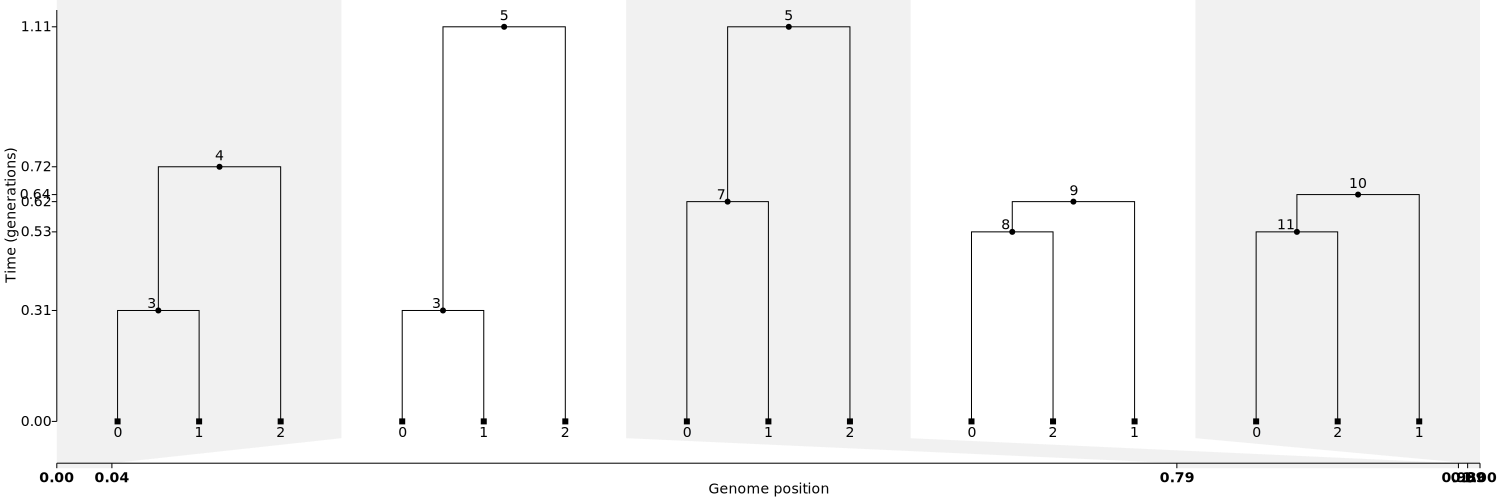

In [236]:
# Validate the new tables to be converted to a tree-sequence.
smc_tables.sort()
# Build the new index for the tree-sequence.
smc_tables.build_index()
# Create the new tree-sequence.
smc_ts = smc_tables.tree_sequence()
#print(smc_ts.draw_text())
smc_ts.draw_svg(
    size=(1500, 500),
    y_axis=True,
)

In [237]:
edge_table

id,left,right,parent,child,metadata
0,0.00000000,0.78699073,3,0,
1,0.00000000,0.78699073,3,1,
2,0.98483549,0.99131411,8,0,
3,0.98483549,0.99131411,8,2,
4,0.99131411,1.00000000,11,0,
5,0.99131411,1.00000000,11,2,
6,0.78699073,0.98483549,7,0,
7,0.78699073,0.98483549,7,1,
8,0.98483549,0.99131411,9,1,
9,0.98483549,0.99131411,9,8,


In [238]:
node_table

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,0,1,0.00000000,
2,1,0,2,0.00000000,
3,0,0,-1,0.31284539,
4,0,0,-1,0.71814239,
5,0,0,-1,1.11291359,
6,0,0,-1,0.71814239,
7,0,0,-1,0.61981943,
8,0,0,-1,0.53456492,
9,0,0,-1,0.61981943,


## ARG Approach

In [26]:
# Intialize a node class.
class Node:
    
    # Intialize the node.
    def __init__(self, node_id, age, node_type, parent=None, l_child=None, r_child=None):
        """
        Node Types
            - 0: leaf node
            - 1: coalescent event node
            - 2: visibile recombination
            - 3: hidden recombination
        """
        self.node_id = node_id
        self.age = age
        self.node_type = node_type
        self.parent = parent
        self.l_child = l_child
        self.r_child = r_child
        self.parent_dist = None
        self.l_child_dist = None
        self.r_child_dist = None
        self.tskit_id = node_id
            
    # Define a method to check if a node is a leaf.
    def is_leaf(self):
        """
        True if the node is a leaf, False otherwise.
        """
        return self.node_type == 0
    
    # Define a method to compute the distance to the children.
    def dist_to_children(self):
        """
        Compute the distance from the current node to its children.
        """
        if self.l_child is not None:
            self.l_child_dist = self.age - self.l_child.age
        if self.r_child is not None:
            self.r_child_dist = self.age - self.r_child.age
    
    # Define a method to compute the distance to the parent node.
    def dist_to_parent(self):
        """
        Compute the distance from the current node to its parent.
        """
        if self.parent is not None:
            self.parent_dist = self.parent.age - self.age
            
    # Define a function to initialize distance to parent and children nodes.
    def init_dists(self):
        """
        Intialize the distances to the parent and children nodes.
        """
        self.dist_to_parent()
        self.dist_to_children()
    
#     # Define a method to copy a node.
#     def copy(self):
#         """
#         TO-DO: if this is needed fix to return a deepcopy instead of a shallow copy.
#         Copies the given node information.
#         """
#         # Copy the node.
#         copied_node = Node(
#             self.node_id, self.age, self.node_type,
#             self.parent, self.l_child, self.r_child,
#         )
#         copied_node.tskit_id = self.tskit_id
#         return copied_node
    
# Intialize an tree class.
class Tree:
    
    # Intialize the tree.
    def __init__(self, left=0.0, right=1.0):
        self.left = left
        self.right = right
        self.root = None
        self.length = None
        self.next_node_id = None
        self.nodes = {}
        self.edges = {}
        self.upper_bounds = None
        self.rec_node = None
        self.recoal_node = None
        
    # Define a method to add a node to the tree.
    def add_node(self, node):
        """
        Add a new node to the tree.
        """
        self.nodes[node.node_id] = node
        
    # Define a method to remove a node from the tree.
    def rmv_node(self, node):
        """
        Remove a new node to the tree.
        """
        del self.nodes[node.node_id]
        
    # Define a method to intialize the edges on a tree.
    def init_edges(self):
        """
        Intialize all the edges on the current tree.
        """
        # Intialize variables.
        i = 0
        Lx = 0
        upper_bounds = []
        # For every node.
        for node in self.nodes:
            # If the node is not a leaf.
            if not self.nodes[node].is_leaf():
                # Record the interval's upper bound.
                upper_bounds.append(self.nodes[node].age)
                # Intialize the edge for parent -> left child.
                self.edges[i] = {}
                self.edges[i]['parent'] = self.nodes[node].node_id
                self.edges[i]['child'] = self.nodes[node].l_child.node_id
                self.edges[i]['upper'] = self.nodes[node].age
                self.edges[i]['lower'] = self.nodes[node].l_child.age
                self.edges[i]['length'] = self.nodes[node].l_child_dist
                i += 1
                Lx += self.nodes[node].l_child_dist
                # Intialize the edge for parent -> right child.
                self.edges[i] = {}
                self.edges[i]['parent'] = self.nodes[node].node_id
                self.edges[i]['child'] = self.nodes[node].r_child.node_id
                self.edges[i]['upper'] = self.nodes[node].age
                self.edges[i]['lower'] = self.nodes[node].r_child.age
                self.edges[i]['length'] = self.nodes[node].r_child_dist
                i += 1
                Lx += self.nodes[node].r_child_dist
        # Set the tree properties.
        self.upper_bounds = sorted(upper_bounds)
        self.length = Lx
                
    # Define a method to find the root node
    def find_root(self):
        """
        Determine the root node on the current tree.
        """
        root_node = max(self.nodes, key=lambda k: self.nodes[k].age)
        self.root = root_node
        
    # Define a method to replace an exiting node on the tree with a new node.
    def replace_node(self, old_node, new_node):
        """
        Replace a node's existing parent node.
        """
        # If the old node has a left child.
        if old_node.l_child is not None:
            # Update the parent of the left child with the new node and recompute the edge length.
            self.nodes[old_node.l_child.node_id].parent = new_node
            self.nodes[old_node.l_child.node_id].dist_to_parent()
        # If the old node has a right child.
        if old_node.r_child is not None:
            # Update the parent of the right child with the new node and recompute the edge length.
            self.nodes[old_node.r_child.node_id].parent = new_node
            self.nodes[old_node.r_child.node_id].dist_to_parent()
        # If the old node is not the root node.
        if old_node.parent is not None:
            # Determine if the old node is the left or right child and recompute the edge length.
            if self.nodes[old_node.parent.node_id].l_child.node_id == old_node.node_id:
                self.nodes[old_node.parent.node_id].l_child = new_node
                self.nodes[old_node.parent.node_id].dist_to_children()
            if self.nodes[old_node.parent.node_id].r_child.node_id == old_node.node_id:
                self.nodes[old_node.parent.node_id].r_child = new_node
                self.nodes[old_node.parent.node_id].dist_to_children()
        # Remove the old node from the tree and add the new node.
        self.rmv_node(old_node)
        self.add_node(new_node)
    
    # Define a function to set the next node id.
    def init_next_node_id(self):
        """
        Set the next node id.
        """
        self.next_node_id = max(self.nodes) + 1

In [46]:
# Define a function to intialize T_{0}.
def init_T0(k, Ne, ploidy, seed=None):
    """
    Returns a tree object and the tskit table of the first tree.
    
    k      -- Number of chromosomes to simulate.
    Ne     -- Effective population size.
    ploidy -- Haploid or diploid coalescent units.
    seed   -- Random seed for reporducibility.
    """
    # Simulate a tree under the standard coalescent.
    ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(k, ploidy=1)],
        population_size=Ne,
        ploidy=ploidy,
        random_seed=seed,
        discrete_genome=False,
    )
    # Make a copy of the tree-seq tables for editting.
    ts_tables = ts.dump_tables()
    print(ts.draw_text())
    return ts_tables



In [33]:
ts_tables = init_T0(k=3, Ne=1, ploidy=2, seed=42)

In [35]:
## (0) Intialize the inputs for the the SMC/SMC' algorithim. ###

k = 3
Ne = 1
rho = 1
ploidy = 2
seed = 42

## (1) Intialize the first tree, T(x)=T_{0}, at position x=0, and compute the total branch length L(x)=L_{0}. ##




# Intialize a tree.
c_tree = Tree()
# For ever node.
for node_id, age in enumerate(ts_tables.nodes.time):
    # If the node is a leaf.
    if age == 0:
        # Intialize the node.
        node = Node(
            node_id=node_id, age=age, node_type=0,
            parent=None, l_child=None, r_child=None,
        )
        # Add the node to the tree.
        c_tree.add_node(node)
    # Else, the node is an ancestral node.
    else:
        # Intialize the node.
        node = Node(
            node_id=node_id, age=age, node_type=1,
            parent=None, l_child=None, r_child=None,
        )
        # Add the node to the tree.
        c_tree.add_node(node)
# For every parent node.
for parent in np.unique(ts_tables.edges.parent):
    # Find the children of the parent node.
    left_child, right_child = tab.edges[tab.edges.parent == parent].child
    # Update the parent node for the two children.
    c_tree.nodes[left_child].parent = c_tree.nodes[parent]
    c_tree.nodes[right_child].parent = c_tree.nodes[parent]
    # Update the children nodes for the parent.
    c_tree.nodes[parent].l_child = c_tree.nodes[left_child]
    c_tree.nodes[parent].r_child = c_tree.nodes[right_child]
# For every node.
for node in c_tree.nodes:
    # Intialize branch lengths.
    c_tree.nodes[node].init_dists()
# Intialize the edges for the current tree.
c_tree.init_edges()
# Intialize the root node.
c_tree.find_root()
# Intialize the next node id.
c_tree.init_next_node_id()

In [40]:
for node in c_tree.nodes:
    if c_tree.nodes[node].is_leaf():
        print(c_tree.nodes[node].node_id, c_tree.nodes[node].parent.node_id)
    else:
        print(c_tree.nodes[node].node_id, c_tree.nodes[node].l_child.node_id, c_tree.nodes[node].r_child.node_id)

0 3
1 3
2 4
3 0 1
4 2 3


In [41]:
for edge in c_tree.edges:
    print(c_tree.edges[edge])

{'parent': 3, 'child': 0, 'upper': 0.3128453884812263, 'lower': 0.0, 'length': 0.3128453884812263}
{'parent': 3, 'child': 1, 'upper': 0.3128453884812263, 'lower': 0.0, 'length': 0.3128453884812263}
{'parent': 4, 'child': 2, 'upper': 0.7181423917434264, 'lower': 0.0, 'length': 0.7181423917434264}
{'parent': 4, 'child': 3, 'upper': 0.7181423917434264, 'lower': 0.3128453884812263, 'length': 0.40529700326220014}
